In [210]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling1D, Flatten, Conv1D, TimeDistributed
from  tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random as python_random

# Ustawienie globalnych ziaren dla reprodukowalności
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [185]:
df = pd.read_csv('full_hand_data_big_set.csv')

# df.dropna(inplace=True)

# correlation_columns = ['left_landmark_1_z', 'left_landmark_2_z', 'left_landmark_3_z', 'left_landmark_4_z', 'left_landmark_12_x', 'left_landmark_12_y', 'left_landmark_11_y', 'left_landmark_11_x', 'left_landmark_8_x', 'left_landmark_10_y', 'left_landmark_19_y', 'left_landmark_20_y', 'left_landmark_7_y', 'left_landmark_8_y', 'left_landmark_14_y', 'left_landmark_18_y', 'left_landmark_15_y', 'left_landmark_10_x', 'left_landmark_6_y', 'left_landmark_7_x', 'left_landmark_17_z', 'video_id', 'label', 'frame_id']

# record_columns = df[correlation_columns]

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])
categorical_labels = to_categorical(encoded_labels)

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [186]:
df['data'] = df['data'].apply(eval)
features = np.array(df['data'].tolist())

# features = df.drop(['label', 'video_id', 'frame_id'], axis=1).values

grouped = df.groupby('video_id').apply(lambda x: x.sort_values('frame_id')).reset_index(drop=True)

max_sequence_length_per_video = grouped.groupby('video_id')['frame_id'].count().max()

X = np.zeros((len(grouped['video_id'].unique()), max_sequence_length_per_video, features.shape[1]))
y = np.zeros((len(grouped['video_id'].unique()), categorical_labels.shape[1]))

for i, (video_id, group) in enumerate(grouped.groupby('video_id')):
    X[i, :len(group)] = np.array(group['data'].tolist())
    y[i] = categorical_labels[group.index[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
model = Sequential()
model.add(Conv1D(200, kernel_size=2, activation = 'relu', input_shape=(max_sequence_length_per_video, features.shape[1])))
model.add(Conv1D(200, kernel_size=2, activation = 'relu'))
model.add(MaxPooling1D(3))


model.add(LSTM(160, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(160))

model.add(Dense(y_train.shape[1], activation='softmax')) # albo softmax albo sigmoid

optimizer = optimizers.Adam(learning_rate=0.0002)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

2024-03-03 15:43:15.875101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 15:43:15.877228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 15:43:15.878252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [233]:
# early_stopping = EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100


2024-03-03 15:43:18.089531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 15:43:18.091433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 15:43:18.092536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - ETA: 0s - loss: 1.4096 - categorical_accuracy: 0.1826

2024-03-03 15:43:22.430623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 15:43:22.431648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 15:43:22.433656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 6s 482ms/step - loss: 1.4096 - categorical_accuracy: 0.1826 - val_loss: 1.3795 - val_categorical_accuracy: 0.4828
Epoch 2/100
4/4 [==============================] - 1s 247ms/step - loss: 1.3238 - categorical_accuracy: 0.4783 - val_loss: 1.3069 - val_categorical_accuracy: 0.3448
Epoch 3/100
4/4 [==============================] - 1s 240ms/step - loss: 1.1812 - categorical_accuracy: 0.5652 - val_loss: 1.0964 - val_categorical_accuracy: 0.5862
Epoch 4/100
4/4 [==============================] - 1s 225ms/step - loss: 0.8936 - categorical_accuracy: 0.5565 - val_loss: 0.8860 - val_categorical_accuracy: 0.6552
Epoch 5/100
4/4 [==============================] - 1s 216ms/step - loss: 0.6070 - categorical_accuracy: 0.7478 - val_loss: 0.7900 - val_categorical_accuracy: 0.7586
Epoch 6/100
4/4 [==============================] - 1s 226ms/step - loss: 0.3651 - categorical_accuracy: 0.9130 - val_loss: 0.4838 - val_categorical_accuracy: 0.8621
Epoch 7/100
4/4 [=====

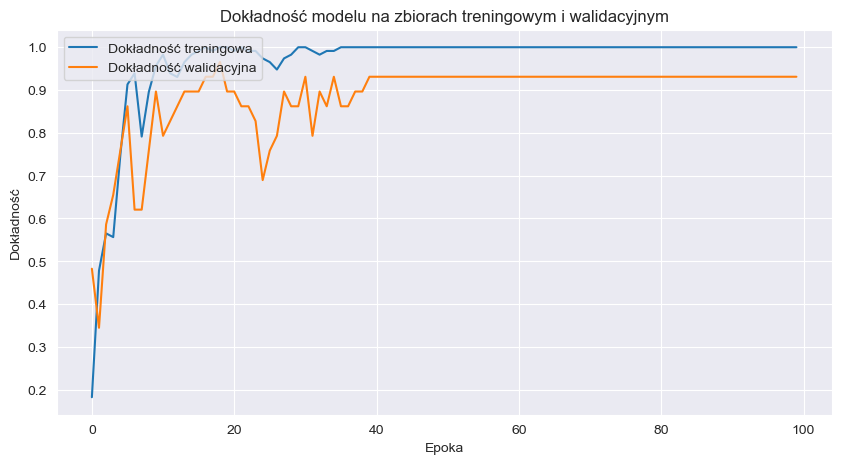

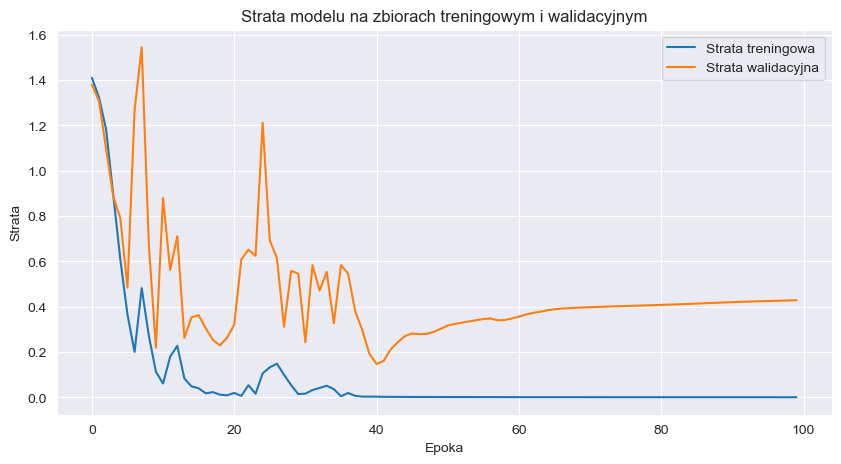

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_categorical_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu na zbiorach treningowym i walidacyjnym')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu na zbiorach treningowym i walidacyjnym')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()


2024-03-03 16:59:41.110305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-03 16:59:41.111839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-03 16:59:41.113377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 880ms/step


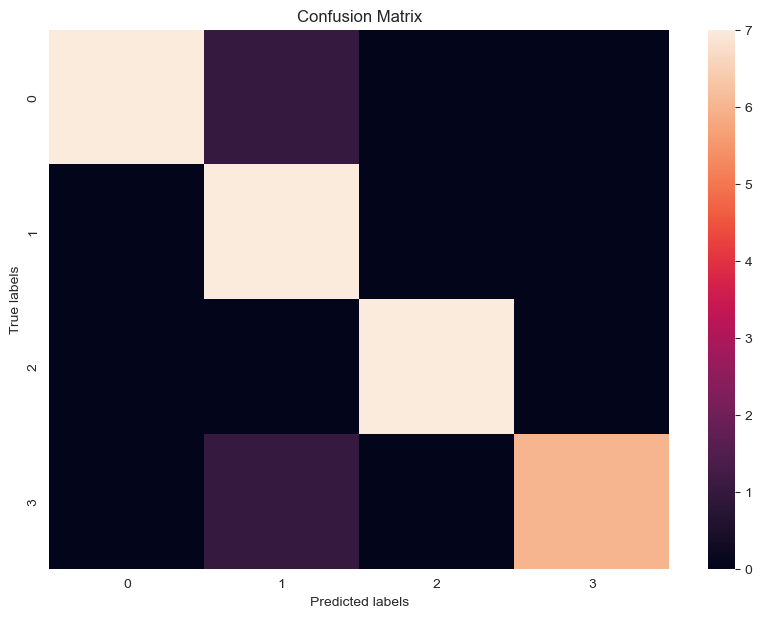

In [235]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [236]:
from sklearn.metrics import classification_report

class_labels = df['label'].unique()

print(classification_report(y_test_class, y_pred_class, target_names=class_labels))

              precision    recall  f1-score   support

           A       1.00      0.88      0.93         8
           C       0.78      1.00      0.88         7
           D       1.00      1.00      1.00         7
           B       1.00      0.86      0.92         7

    accuracy                           0.93        29
   macro avg       0.94      0.93      0.93        29
weighted avg       0.95      0.93      0.93        29

